# Custom TTNet Implementation

## Setup

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import utils as vutils

### GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(0)))

# Turns on cuDNN Autotuner
torch.backends.cudnn.benchmark = True

Device: cuda:0
GPU: NVIDIA GeForce RTX 2080 Ti


### TTNet Params

In [3]:
# Folder paths
dataset_base_path = './Dataset/images'
savePath_base = "./Trained_Models/"
savePath = savePath_base+"TTNet.pth"
outputPath = "./Results/TTNet_Results/"

# Create folders if they dont exist
if not os.path.exists(outputPath): os.makedirs(outputPath)
if not os.path.exists(savePath_base): os.makedirs(savePath_base)

# Train/Test/Validation split
#train_list = [f"{x:02}" for x in range(1,25)]   # "01" to "24"
#test_list = [f"{x:02}" for x in range(25,28)]   # "25" to "27"
#val_list = [f"{x:02}" for x in range(28,31)]    # "28" to "30"

train_list = [f"{x:02}" for x in range(1,31)]   # "01" to "24"
test_list = [f"{x:02}" for x in range(1,31)]   # "25" to "27"
val_list = [f"{x:02}" for x in range(1,31)]    # "28" to "30"
train_start_no, train_end_no = 0, 1440
test_start_no, test_end_no = 1440, 1620
val_start_no, val_end_no = 1620, 1800

# Training parameters
train_batch = 8
val_batch = 8
test_batch = 8
num_workers = 16
learning_rate = 1e-4
shuffle_data = True
eps = 1e-4
sigma = 1
event_num = 5 # 0: Nothing, 1: Flying, 2: Bounce, 3: Racket Contact, 4: Net Contact

# Img resolution in dataset
data_width = 1920
data_height = 1080 
# The size the images are downscaled to when being fed to the model
TTN_width=640
TTN_height=320

seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Datset

In [4]:
# TODO This entire section probably needs a rewrite
transform = transforms.Compose([
  transforms.Resize((TTN_height,TTN_width)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def default_loader(img_path):
  img_tensor = transform(Image.open(img_path))
  return img_tensor

def getOutputArr(path,w=TTN_width,h=TTN_height):
  seg_img = cv.imread(path)
  seg_img = cv.resize(seg_img, (TTN_width , TTN_height ))
  seg_img = cv.cvtColor(seg_img,cv.COLOR_BGR2RGB)
  seg_img = seg_img.transpose(2,0,1).astype(float)
  seg_img[seg_img<75]=0
  seg_img[seg_img>75]=1
  return seg_img

def smooth_event(events,event_num):
  event_idx = event_num
  is_found = False
  for i in range((len(events)+1)//2):
    middle_index =  (len(events))//2
    if((int(events[middle_index+i])==event_num or int(events[middle_index-i])==event_num) and not is_found):
      event_idx = i
      is_found = True
  n = event_idx
  prob = np.cos(n * np.pi / 8)
  if(prob<0.01):
    return 0
  else:
    return prob

### Training

In [5]:
class train_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(train_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not(train_start_no+window_size-1 < frame_no <= train_end_no-1):
          continue
        #if not (window_size-1 < frame_no <= len(self.img_paths)-1):
        #  continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Test

In [6]:
class test_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(test_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not(test_start_no+window_size-1 < frame_no <= test_end_no-1):
          continue
        #if not (window_size-1 < frame_no <= len(self.img_paths)-1):
        #  continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob) 

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Validation

In [7]:
class val_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(val_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not(val_start_no+window_size-1 < frame_no <= val_end_no-1):
          continue
        #if not (window_size-1 < frame_no <= len(self.img_paths)-1):
        #  continue

      # Get frame window image paths
      window_path = []
      middle_index = frame_no-self.window_size+(self.window_size+1)//2
      for window_frame in range(self.window_size):
        window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
      self.window_paths.append(window_path)

      # Downscaling ball xy coords into lower resolution(?)
      x_downscale = self.ball_x[middle_index]/data_width*TTN_width
      y_downscale = self.ball_y[middle_index]/data_height*TTN_height
      self.xy_downscale.append([x_downscale, y_downscale])

      # Smooth events
      event_prob = torch.zeros((event_num))
      for i in range(event_num):
        event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
      self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]
    
    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Load Datasets

In [8]:
print("Loading train set...")
dataset_total  = train_data_loader()
train_loader = DataLoader(dataset_total, batch_size=train_batch,shuffle=shuffle_data,num_workers=num_workers,pin_memory=True,drop_last=True)

print("Loading validation set...")
dataset_val  = val_data_loader()
val_loader = DataLoader(dataset_val, batch_size=val_batch,shuffle=False,num_workers=num_workers,pin_memory=True)

print("Loading test set...")
dataset_test  = test_data_loader()
test_loader = DataLoader(dataset_test, batch_size=test_batch,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)

img_shape = train_loader.dataset[0][0].shape
print(img_shape)
print(len(train_loader))
print("Dataset total batches:")
print(f"Training : {len(train_loader)}")
print(f"Validation : {len(val_loader)}")
print(f"Test : {len(test_loader)}")

Loading train set...
Loading validation set...
Loading test set...
torch.Size([27, 320, 640])
5366
Dataset total batches:
Training : 5366
Validation : 4
Test : 641


## Losses

In [9]:
# TODO This entire section probably needs a rewrite
def gaussian_1d(pos, mu, sigma):
  target = torch.exp(- (((pos - mu) / sigma) ** 2) / 2)
  return target

def ball_loss(pre_output,true_label):
  x_pred = pre_output[:, :TTN_width]
  y_pred = pre_output[:, TTN_width:]

  target_output = torch.zeros_like(pre_output)
  for i in range(pre_output.shape[0]):
    target_output_temp = torch.zeros((TTN_width+TTN_height), device=device)
    x,y = true_label[i]
    if (TTN_width > x > 0) and (TTN_height > y > 0):    
      x_axis = torch.arange(0, TTN_width, device=device)
      y_axis = torch.arange(0, TTN_height, device=device)

      target_output_temp[:TTN_width] = gaussian_1d(x_axis, x, sigma=sigma)
      target_output_temp[TTN_width:] = gaussian_1d(y_axis, y, sigma=sigma)
      target_output_temp[target_output_temp < 1e-2] = 0.
    target_output[i] = target_output_temp
    
  x_target = target_output[:, :TTN_width]
  y_target = target_output[:, TTN_width:]

  loss_x = - torch.mean(x_target * torch.log(x_pred + eps) + (1 - x_target) * torch.log(1 - x_pred + eps))
  loss_y = - torch.mean(y_target * torch.log(y_pred + eps) + (1 - y_target) * torch.log(1 - y_pred + eps))
  loss = loss_x+loss_y
  return loss

def event_loss(pre_output,true_label):
  weights = (3,1,3,3,3)
  weights = torch.tensor(weights).to(device)
  weights = weights.view(-1,weights.shape[0])
  weights = weights / weights.sum()
  loss = -torch.mean(weights * (true_label * torch.log(pre_output + eps) + (1. - true_label) * torch.log(1 - pre_output + eps)))
  return loss


## TTNet Config

### Define Block Types

In [10]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),          
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0,ceil_mode=True),
    )
    
  def forward(self, x):
    out = self.block(x)
    return out

class ConvBlock_without_Pooling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock_without_Pooling, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )

  def forward(self, x):
    out = self.block(x)
    return out

### Define Segments

In [11]:
class BallDetection(nn.Module):
  def __init__(self, frame_window, dropout_p):
    super(BallDetection, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(in_channels = frame_window*3, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64,track_running_stats=False),
      nn.ReLU(inplace=True),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=128),
      ConvBlock(in_channels=128, out_channels=128),
      ConvBlock(in_channels=128, out_channels=256),
      ConvBlock(in_channels=256, out_channels=256)
    )
    self.FC1 = nn.Sequential(
      nn.Linear(in_features=12800, out_features=5584),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC2 = nn.Sequential(
      nn.Linear(in_features=5584, out_features=1896),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC3 = nn.Sequential(
      nn.Linear(in_features=1896, out_features=int(TTN_width+TTN_height)),
      nn.Sigmoid(),
    )
    self.dropout2d = nn.Dropout2d(p=dropout_p)

  def forward(self, x):
    block6_out = self.convBlocks(x)
    x = self.dropout2d(block6_out)
    x = x.contiguous().view(x.shape[0], -1)
    x = self.FC1(x)
    x = self.FC2(x)
    out = self.FC3(x)

    return out, block6_out

class EventSpotting(nn.Module):
  def __init__(self, dropout_p):
    super(EventSpotting, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
    )
    self.FC = nn.Sequential(           
      nn.Linear(in_features=3200, out_features=2048),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=event_num),
      nn.Sigmoid()
    )

  def forward(self, global_features, local_features):
    x = torch.cat((global_features, local_features), dim=1)
    x = self.convBlocks(x)
    x = x.contiguous().view(x.size(0), -1)
    out = self.FC(x)
    
    return out

### TTNet Model

In [12]:
class TTNet(nn.Module):
  def __init__(self, dropout_p, frame_window, threshold, tasks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    super(TTNet, self).__init__() 
    # Assign stages
    self.local_stage,self.event_spotting = None,None
    self.global_stage = BallDetection(frame_window, dropout_p)
    if "local" in tasks:
      self.local_stage = BallDetection(frame_window, dropout_p)
    if "event" in tasks:
      self.event_spotting = EventSpotting(dropout_p)

    self.threshold = threshold
    self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
    self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

  # TODO look into normalising the inputs
  def forward(self, x):
    local_out, local_in, crop_params, event_out = None, None, None, None

    global_out, global_features = self.global_stage(self.norm(x))
    if self.local_stage is not None:
      local_in, crop_params = self.crop_imgs(x, global_out)
      local_out, local_features, *_ = self.local_stage(self.norm(local_in))
      if self.event_spotting is not None:
        event_out = self.event_spotting(global_features, local_features)
    
    return global_out, local_out, local_in, crop_params, event_out

  # TODO This section needs a rewrite
  def crop_imgs(self, x, global_xy):
    global_xy_copy = global_xy.detach().clone()
    global_xy_copy[global_xy_copy < self.threshold] = 0
    crop_params = []
    ball_detected = False

    global_output = torch.zeros_like(x)
    # original size
    original_input = F.interpolate(x, (data_height, data_width))
    ####
    for i in range(x.shape[0]):
      pos_x = global_xy_copy[i, :TTN_width]
      pos_y = global_xy_copy[i, TTN_width:]

      if (torch.sum(pos_x) == 0) or (torch.sum(pos_y) == 0):
        x_center = int(TTN_width / 2)
        y_center = int(TTN_height / 2)
      else:
        x_center = torch.argmax(pos_x)
        y_center = torch.argmax(pos_y)
        ball_detected = True

      # original size
      x_center = int(x_center * (data_width/TTN_width))
      y_center = int(y_center * (data_height/TTN_height))
      x_min = max(0, x_center - int(TTN_width / 2))
      y_min = max(0, y_center - int(TTN_height / 2))
      x_max = min(data_width, x_min + TTN_width)
      y_max = min(data_height, y_min + TTN_height)
      crop_width = x_max - x_min
      crop_height = y_max - y_min
      padding_x=padding_y=0
      if (crop_height != TTN_height) or (crop_width != TTN_width):
        padding_x = int((TTN_width - crop_width) / 2)
        padding_y = int((TTN_height - crop_height) / 2)
        global_output[i, :, padding_y:(padding_y + crop_height), padding_x:(padding_x + crop_width)] = original_input[i, :,y_min:y_max, x_min: x_max]
      else:
        global_output[i, :, :, :] = original_input[i, :, y_min:y_max, x_min: x_max]
      crop_params.append([ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y])


    return global_output,crop_params

  def norm(self,x):
    if not self.mean.is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()

    return (x / 255. - self.mean) / self.std

def freeze_model(model, freeze_list):
  for layer_name, p in model.named_parameters():
    p.requires_grad = True
    for freeze_module in freeze_list:
      if freeze_module in layer_name:
        print("Freeze layer :"+freeze_module)
        p.requires_grad = False
        break
  return model

# TODO Rewrite this
def get_local_groundtruth(global_ball_pos_xyz,crop_params):
  
  local_ball_pos_xyz = []
  for i,para in enumerate(crop_params):
    ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = para
    if ball_detected:
      ori_x = global_ball_pos_xyz[0][i].item()/TTN_width*data_width
      ori_y = global_ball_pos_xyz[1][i].item()/TTN_height*data_height
      local_x = max(ori_x - x_min + padding_x, -1)
      local_y = max(ori_y - y_min + padding_y, -1)

      if not (TTN_width>local_x>=0 and TTN_height>local_y>=0):
        local_x = local_y = -1
     
    else:
      local_x = local_y = -1
    local_ball_pos_xyz.append([local_x,local_y])

  return local_ball_pos_xyz

## Traning Phase 1

In [13]:
# Training config
model_saved = True
ph1_epochs = 30
global_weight = 5
ph1_train_loss_log = []
ph1_val_loss_log = []

In [14]:
# Create model
tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Loading model from path: ./Trained_Models/Phase1_new_val_2/TTNet_Phase1_9.pth
Load phase 1 at epoch 9 succeed
START TO TRAIN PHASE 1: Global Stage ...
Train	 epoch: 10/30	 batch: 500/2683	 loss: 0.16815167665481567
Train	 epoch: 10/30	 batch: 1000/2683	 loss: 0.2160954773426056
Train	 epoch: 10/30	 batch: 1500/2683	 loss: 0.18797136843204498
Train	 epoch: 10/30	 batch: 2000/2683	 loss: 0.13872577250003815
Train	 epoch: 10/30	 batch: 2500/2683	 loss: 0.21580442786216736
Train	 epoch: 10/30	 loss: 0.17538011767750483
Validation	 epoch: 10/30	 loss: 0.271279439330101
Saving model


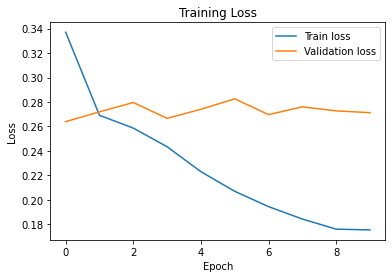

Train	 epoch: 11/30	 batch: 500/2683	 loss: 0.15326079726219177
Train	 epoch: 11/30	 batch: 1000/2683	 loss: 0.1695326268672943
Train	 epoch: 11/30	 batch: 1500/2683	 loss: 0.14322297275066376
Train	 epoch: 11/30	 batch: 2000/2683	 loss: 0.15749064087867737
Train	 epoch: 11/30	 batch: 2500/2683	 loss: 0.13618844747543335
Train	 epoch: 11/30	 loss: 0.1667409391516276
Validation	 epoch: 11/30	 loss: 0.27210189402103424
Saving model


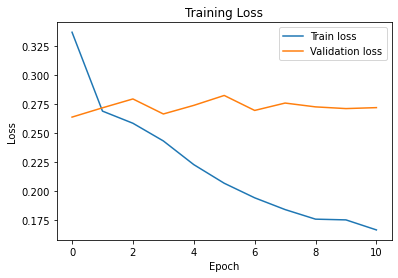

Train	 epoch: 12/30	 batch: 500/2683	 loss: 0.1926001012325287
Train	 epoch: 12/30	 batch: 1000/2683	 loss: 0.15595777332782745
Train	 epoch: 12/30	 batch: 1500/2683	 loss: 0.14828301966190338
Train	 epoch: 12/30	 batch: 2000/2683	 loss: 0.1429123878479004
Train	 epoch: 12/30	 batch: 2500/2683	 loss: 0.18292176723480225
Train	 epoch: 12/30	 loss: 0.16056782082472992
Validation	 epoch: 12/30	 loss: 0.3109728991985321
Saving model


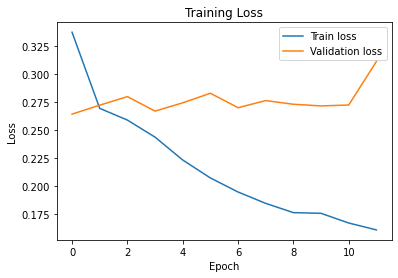

Train	 epoch: 13/30	 batch: 500/2683	 loss: 0.14578555524349213
Train	 epoch: 13/30	 batch: 1000/2683	 loss: 0.15025411546230316
Train	 epoch: 13/30	 batch: 1500/2683	 loss: 0.1686653196811676
Train	 epoch: 13/30	 batch: 2000/2683	 loss: 0.183090940117836
Train	 epoch: 13/30	 batch: 2500/2683	 loss: 0.13693158328533173
Train	 epoch: 13/30	 loss: 0.15513174533788454
Validation	 epoch: 13/30	 loss: 0.27126292884349823
Saving model


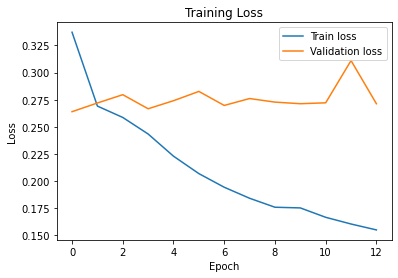

Train	 epoch: 14/30	 batch: 500/2683	 loss: 0.11425770074129105
Train	 epoch: 14/30	 batch: 1000/2683	 loss: 0.13677978515625
Train	 epoch: 14/30	 batch: 1500/2683	 loss: 0.17598526179790497
Train	 epoch: 14/30	 batch: 2000/2683	 loss: 0.15439638495445251
Train	 epoch: 14/30	 batch: 2500/2683	 loss: 0.10902279615402222
Train	 epoch: 14/30	 loss: 0.1500469559759868
Validation	 epoch: 14/30	 loss: 0.27047298848629
Saving model


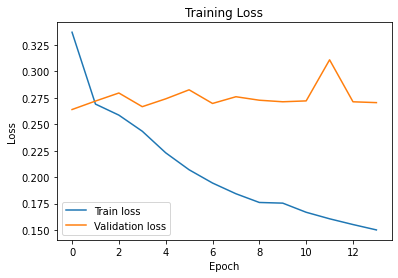

Train	 epoch: 15/30	 batch: 500/2683	 loss: 0.13976484537124634
Train	 epoch: 15/30	 batch: 1000/2683	 loss: 0.11627320200204849
Train	 epoch: 15/30	 batch: 1500/2683	 loss: 0.13228635489940643
Train	 epoch: 15/30	 batch: 2000/2683	 loss: 0.15165841579437256
Train	 epoch: 15/30	 batch: 2500/2683	 loss: 0.1541643738746643
Train	 epoch: 15/30	 loss: 0.14513048047822577
Validation	 epoch: 15/30	 loss: 0.26587431877851486
Saving model


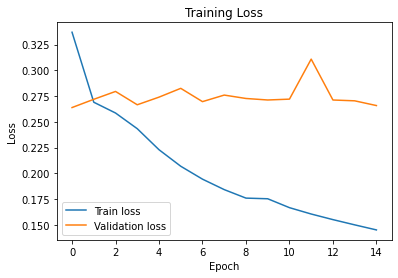

Train	 epoch: 16/30	 batch: 500/2683	 loss: 0.15247584879398346
Train	 epoch: 16/30	 batch: 1000/2683	 loss: 0.13655316829681396
Train	 epoch: 16/30	 batch: 1500/2683	 loss: 0.14709828794002533
Train	 epoch: 16/30	 batch: 2000/2683	 loss: 0.1427450180053711
Train	 epoch: 16/30	 batch: 2500/2683	 loss: 0.16570988297462463
Train	 epoch: 16/30	 loss: 0.14154863723269426
Validation	 epoch: 16/30	 loss: 0.26211627572774887
Saving model


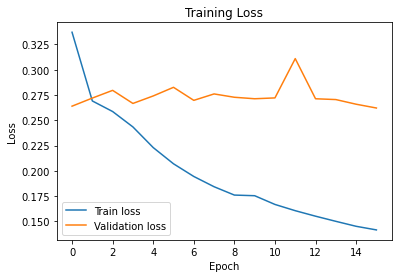

Train	 epoch: 17/30	 batch: 500/2683	 loss: 0.16039863228797913
Train	 epoch: 17/30	 batch: 1000/2683	 loss: 0.14497101306915283
Train	 epoch: 17/30	 batch: 1500/2683	 loss: 0.1365734338760376
Train	 epoch: 17/30	 batch: 2000/2683	 loss: 0.1010316014289856
Train	 epoch: 17/30	 batch: 2500/2683	 loss: 0.1485637128353119
Train	 epoch: 17/30	 loss: 0.13753081392184416
Validation	 epoch: 17/30	 loss: 0.2708630710840225
Saving model


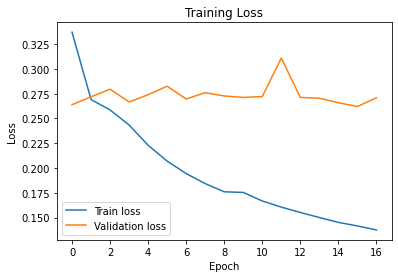

Train	 epoch: 18/30	 batch: 500/2683	 loss: 0.12170088291168213
Train	 epoch: 18/30	 batch: 1000/2683	 loss: 0.13943874835968018
Train	 epoch: 18/30	 batch: 1500/2683	 loss: 0.1254793107509613
Train	 epoch: 18/30	 batch: 2000/2683	 loss: 0.15327680110931396
Train	 epoch: 18/30	 batch: 2500/2683	 loss: 0.1464586853981018
Train	 epoch: 18/30	 loss: 0.1341287141004206
Validation	 epoch: 18/30	 loss: 0.2584226578474045
Saving model


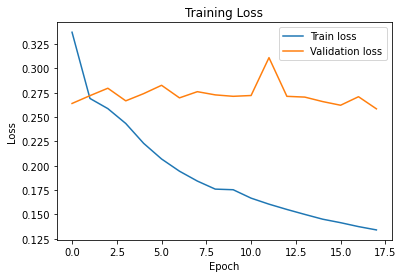

Train	 epoch: 19/30	 batch: 500/2683	 loss: 0.10136506706476212
Train	 epoch: 19/30	 batch: 1000/2683	 loss: 0.15419058501720428
Train	 epoch: 19/30	 batch: 1500/2683	 loss: 0.1342862993478775
Train	 epoch: 19/30	 batch: 2000/2683	 loss: 0.11436797678470612
Train	 epoch: 19/30	 batch: 2500/2683	 loss: 0.13250954449176788
Train	 epoch: 19/30	 loss: 0.13148743002368274
Validation	 epoch: 19/30	 loss: 0.2614683359861374
Saving model


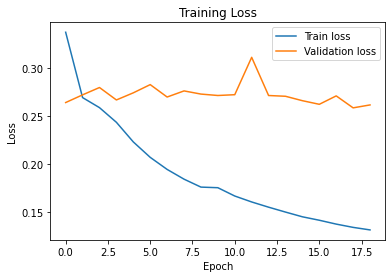

Train	 epoch: 20/30	 batch: 500/2683	 loss: 0.11690334975719452
Train	 epoch: 20/30	 batch: 1000/2683	 loss: 0.1205298900604248
Train	 epoch: 20/30	 batch: 1500/2683	 loss: 0.11527679115533829
Train	 epoch: 20/30	 batch: 2000/2683	 loss: 0.09013723582029343
Train	 epoch: 20/30	 batch: 2500/2683	 loss: 0.12387572228908539
Train	 epoch: 20/30	 loss: 0.12855779807674453
Validation	 epoch: 20/30	 loss: 0.25185494124889374
Saving model


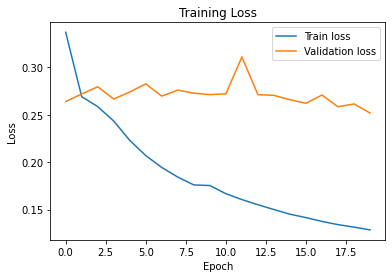

Train	 epoch: 21/30	 batch: 500/2683	 loss: 0.11611250042915344
Train	 epoch: 21/30	 batch: 1000/2683	 loss: 0.11168530583381653
Train	 epoch: 21/30	 batch: 1500/2683	 loss: 0.13047973811626434
Train	 epoch: 21/30	 batch: 2000/2683	 loss: 0.11214172840118408
Train	 epoch: 21/30	 batch: 2500/2683	 loss: 0.0998719334602356
Train	 epoch: 21/30	 loss: 0.12606948513594574
Validation	 epoch: 21/30	 loss: 0.2538398429751396
Saving model


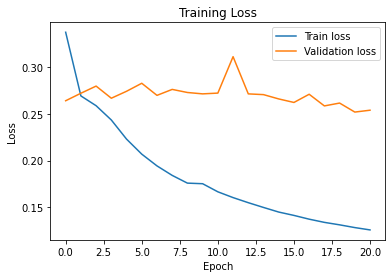

Train	 epoch: 22/30	 batch: 500/2683	 loss: 0.11149998754262924
Train	 epoch: 22/30	 batch: 1000/2683	 loss: 0.11107288300991058
Train	 epoch: 22/30	 batch: 1500/2683	 loss: 0.13319125771522522
Train	 epoch: 22/30	 batch: 2000/2683	 loss: 0.11846501380205154
Train	 epoch: 22/30	 batch: 2500/2683	 loss: 0.13004432618618011
Train	 epoch: 22/30	 loss: 0.12378780536028684
Validation	 epoch: 22/30	 loss: 0.259781576693058
Saving model


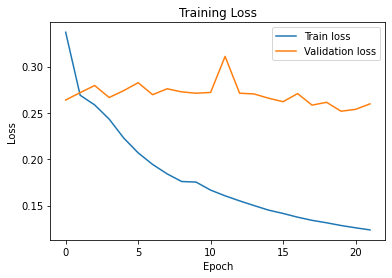

Train	 epoch: 23/30	 batch: 500/2683	 loss: 0.09960279613733292
Train	 epoch: 23/30	 batch: 1000/2683	 loss: 0.10847263038158417
Train	 epoch: 23/30	 batch: 1500/2683	 loss: 0.12941530346870422
Train	 epoch: 23/30	 batch: 2000/2683	 loss: 0.10593060404062271
Train	 epoch: 23/30	 batch: 2500/2683	 loss: 0.16235876083374023
Train	 epoch: 23/30	 loss: 0.12155535933500877
Validation	 epoch: 23/30	 loss: 0.2545623183250427
Saving model


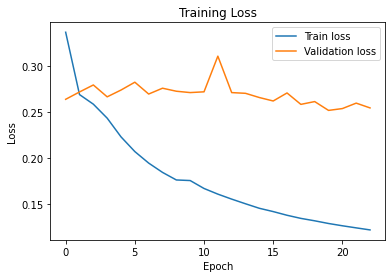

Train	 epoch: 24/30	 batch: 500/2683	 loss: 0.10254555940628052
Train	 epoch: 24/30	 batch: 1000/2683	 loss: 0.1250266134738922
Train	 epoch: 24/30	 batch: 1500/2683	 loss: 0.13118048012256622
Train	 epoch: 24/30	 batch: 2000/2683	 loss: 0.11734476685523987
Train	 epoch: 24/30	 batch: 2500/2683	 loss: 0.11729825288057327
Train	 epoch: 24/30	 loss: 0.11975126685605891
Validation	 epoch: 24/30	 loss: 0.25260841846466064
Saving model


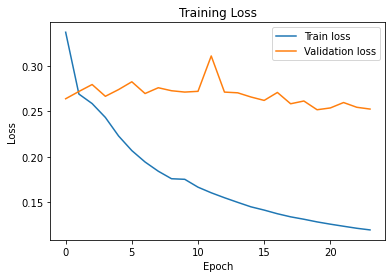

Train	 epoch: 25/30	 batch: 500/2683	 loss: 0.11878086626529694
Train	 epoch: 25/30	 batch: 1000/2683	 loss: 0.12625661492347717
Train	 epoch: 25/30	 batch: 1500/2683	 loss: 0.09134602546691895
Train	 epoch: 25/30	 batch: 2000/2683	 loss: 0.10065442323684692
Train	 epoch: 25/30	 batch: 2500/2683	 loss: 0.09930454194545746
Train	 epoch: 25/30	 loss: 0.11760819987839964
Validation	 epoch: 25/30	 loss: 0.25601619482040405
Saving model


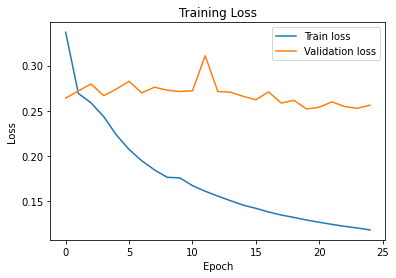

Train	 epoch: 26/30	 batch: 500/2683	 loss: 0.10280826687812805
Train	 epoch: 26/30	 batch: 1000/2683	 loss: 0.1111430674791336
Train	 epoch: 26/30	 batch: 1500/2683	 loss: 0.12066661566495895
Train	 epoch: 26/30	 batch: 2000/2683	 loss: 0.12970617413520813
Train	 epoch: 26/30	 batch: 2500/2683	 loss: 0.1119173914194107
Train	 epoch: 26/30	 loss: 0.11599863691868464
Validation	 epoch: 26/30	 loss: 0.24445027112960815
Saving model


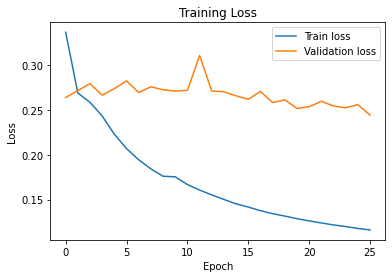

Train	 epoch: 27/30	 batch: 500/2683	 loss: 0.10095606744289398
Train	 epoch: 27/30	 batch: 1000/2683	 loss: 0.10907784104347229
Train	 epoch: 27/30	 batch: 1500/2683	 loss: 0.11538728326559067
Train	 epoch: 27/30	 batch: 2000/2683	 loss: 0.09622391313314438
Train	 epoch: 27/30	 batch: 2500/2683	 loss: 0.10283469408750534
Train	 epoch: 27/30	 loss: 0.11424391640491154
Validation	 epoch: 27/30	 loss: 0.24502405524253845
Saving model


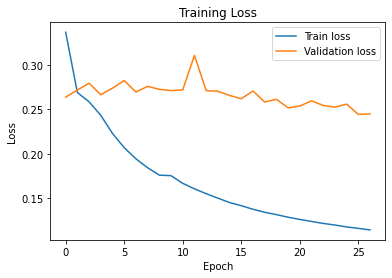

Train	 epoch: 28/30	 batch: 500/2683	 loss: 0.11472836881875992
Train	 epoch: 28/30	 batch: 1000/2683	 loss: 0.11004963517189026
Train	 epoch: 28/30	 batch: 1500/2683	 loss: 0.11947213858366013
Train	 epoch: 28/30	 batch: 2000/2683	 loss: 0.1233704537153244
Train	 epoch: 28/30	 batch: 2500/2683	 loss: 0.12536904215812683
Train	 epoch: 28/30	 loss: 0.11269579809041019
Validation	 epoch: 28/30	 loss: 0.24564295262098312
Saving model


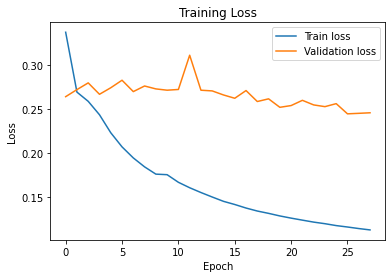

Train	 epoch: 29/30	 batch: 500/2683	 loss: 0.10358958691358566
Train	 epoch: 29/30	 batch: 1000/2683	 loss: 0.08017309755086899
Train	 epoch: 29/30	 batch: 1500/2683	 loss: 0.08445601165294647
Train	 epoch: 29/30	 batch: 2000/2683	 loss: 0.14108827710151672
Train	 epoch: 29/30	 batch: 2500/2683	 loss: 0.12979374825954437
Train	 epoch: 29/30	 loss: 0.11120081677105371
Validation	 epoch: 29/30	 loss: 0.24869036674499512
Saving model


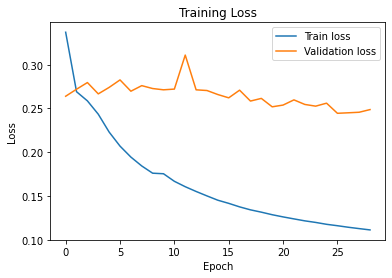

Train	 epoch: 30/30	 batch: 500/2683	 loss: 0.08225839585065842
Train	 epoch: 30/30	 batch: 1000/2683	 loss: 0.11550940573215485
Train	 epoch: 30/30	 batch: 1500/2683	 loss: 0.10435047745704651
Train	 epoch: 30/30	 batch: 2000/2683	 loss: 0.15312425792217255
Train	 epoch: 30/30	 batch: 2500/2683	 loss: 0.12392126023769379
Train	 epoch: 30/30	 loss: 0.1100966980818977
Validation	 epoch: 30/30	 loss: 0.24892579019069672
Saving model


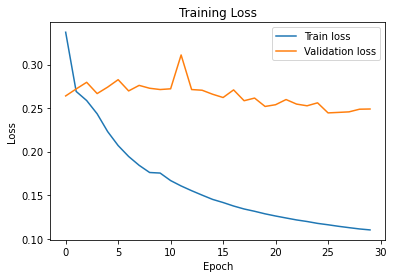

In [15]:
# Train the model
if (model_saved):
  savePath = savePath_base+"Phase1_new_val_2/TTNet_Phase1_9.pth"
  print(f"Loading model from path: {savePath}")
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph1_train_loss_log = checkpoint['train_loss_log']
  ph1_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 1 at epoch {start_epoch} succeed")
else:
  start_epoch = 0
  print("Phase 1: No model to load, start to train at epoch 0")

print("START TO TRAIN PHASE 1: Global Stage ...")
for epoch in range(start_epoch+1, ph1_epochs + 1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, _ = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)
    
    # Calculate train (global) loss
    with autocast():
      global_out, _, _, _, _ = model(window_batch)
      train_loss = ball_loss(global_out,xy_downscale) * global_weight

    #train_loss.backward()
    #optimizer.step()
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    
    train_loss_total += loss
    if((i+1)%500==0):
      print(f"Train\t epoch: {epoch}/{ph1_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

  # Log training losses
  print(f"Train\t epoch: {epoch}/{ph1_epochs}\t loss: {train_loss_total/batch_num}")
  ph1_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():     
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs ,xy_downscale, _,_ = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)      
      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step and calculate val (global) loss
      with autocast():
        global_out, _, _, _, _ = model(window_batch)
        val_loss = ball_loss(global_out,xy_downscale) * global_weight
      
      loss = val_loss.detach().cpu().numpy()
      val_loss_total += loss

    # Log validation losses
    ph1_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph1_epochs}\t loss: {val_loss_total/batch_num}")
  
  print("Saving model")
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph1_train_loss_log,'val_loss_log':ph1_val_loss_log}
  savePath = savePath_base+f"/Phase1_new_val_2/TTNet_Phase1_{epoch}.pth"
  torch.save(state, savePath)
  model_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph1_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph1_val_loss_log,label='Validation loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph1.png")
  plt.show()

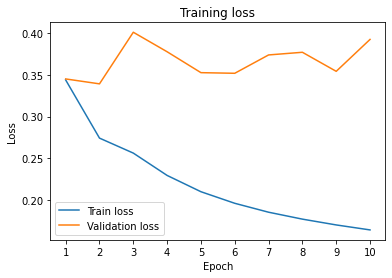

In [20]:
# Plot the losses
plt.clf()
plt.plot(range(epoch),ph1_train_loss_log,label='Train loss')
plt.plot(range(epoch),ph1_val_loss_log,label='Validation loss')
plt.legend()
plt.xticks(range(epoch), range(1,11))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.savefig(outputPath+"loss_ph1.png")
plt.show()

## Phase 2 Test

In [17]:
# Training config
ph2_saved = True
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_val_loss_log = []

In [18]:
freeze_list = ["global_stage"]
tasks = ["local"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}

Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage


In [19]:
if ph2_saved:
  savePath = savePath_base+"Phase2_loc_only/TTNet_Phase2_28.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph2_train_loss_log = checkpoint['train_loss_log']
  ph2_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 2 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase1_new_val/TTNet_Phase1_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  pretrained_dict = load_weights_local_stage(pretrained_dict)
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 2: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 2: Local Stage ...')

for epoch in range(start_epoch+1, ph2_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()
    
    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

    # Model forward step
    with autocast():
      _, local_out, _, crop_params, _ = model(window_batch)

    # Get event probs and local xy predictions
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (local+event) loss
    with autocast():
      train_loss = ball_loss(local_out,local_ball_xy) * local_weight
    
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph2_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainimg losses
  print(f"Train\t epoch: {epoch}/{ph2_epochs}\t loss: {train_loss_total/batch_num}")
  ph2_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      with autocast():
        _, local_out, _, crop_params, _ = model(window_batch)

      # Get event probs and local xy predictions
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (local+event) loss
      with autocast():
        val_loss = ball_loss(local_out,local_ball_xy) * local_weight

      loss = train_loss.detach().cpu().numpy()
      val_loss_total += loss
      #val_loss_total += val_loss.item()

    ph2_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph2_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"Phase2_loc_only/TTNet_Phase2_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph2_train_loss_log,'val_loss_log':ph2_val_loss_log}
  torch.save(state, savePath) 
  ph2_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph2.png")
  plt.show()

Loading model from path: 
./Trained_Models/Phase2_loc_only/TTNet_Phase2_28.pth
Load phase 2 at epoch 28 succeed
START TO TRAIN PHASE 2: Local Stage ...
+ Train	 epoch: 29/30	 batch: 500/5366	 loss: 0.034226302057504654


In [ ]:
# Training config
ph2_saved = False
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_val_loss_log = []

In [ ]:
freeze_list = ["global_stage"]
tasks = ["local"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}

## Training Phase 2

In [13]:
# Training config
ph2_saved = False
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_val_loss_log = []

In [14]:
freeze_list = ["global_stage"]
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}



Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage


Phase 2: No model to load, start to train at epoch 0
START TO TRAIN PHASE 2: Local + Event Stage ...
+ Train	 epoch: 1/30	 batch: 500/5366	 loss: 0.19005033373832703
+ Train	 epoch: 1/30	 batch: 1000/5366	 loss: 0.1861809343099594
+ Train	 epoch: 1/30	 batch: 1500/5366	 loss: 0.19104927778244019
+ Train	 epoch: 1/30	 batch: 2000/5366	 loss: 0.19515380263328552
+ Train	 epoch: 1/30	 batch: 2500/5366	 loss: 0.17574356496334076
+ Train	 epoch: 1/30	 batch: 3000/5366	 loss: 0.2688012421131134
+ Train	 epoch: 1/30	 batch: 3500/5366	 loss: 0.20141367614269257
+ Train	 epoch: 1/30	 batch: 4000/5366	 loss: 0.21585354208946228
+ Train	 epoch: 1/30	 batch: 4500/5366	 loss: 0.23487941920757294
+ Train	 epoch: 1/30	 batch: 5000/5366	 loss: 0.20860421657562256
Train	 epoch: 1/30	 loss: 0.19700424121835095
Validation	 epoch: 1/30	 loss: 0.19825690984725952
Saving model


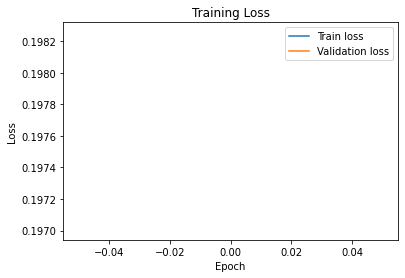

+ Train	 epoch: 2/30	 batch: 500/5366	 loss: 0.19555196166038513
+ Train	 epoch: 2/30	 batch: 1000/5366	 loss: 0.17716985940933228
+ Train	 epoch: 2/30	 batch: 1500/5366	 loss: 0.26481419801712036
+ Train	 epoch: 2/30	 batch: 2000/5366	 loss: 0.19905142486095428
+ Train	 epoch: 2/30	 batch: 2500/5366	 loss: 0.20240074396133423
+ Train	 epoch: 2/30	 batch: 3000/5366	 loss: 0.18615758419036865
+ Train	 epoch: 2/30	 batch: 3500/5366	 loss: 0.2305086851119995
+ Train	 epoch: 2/30	 batch: 4000/5366	 loss: 0.22328341007232666
+ Train	 epoch: 2/30	 batch: 4500/5366	 loss: 0.22520661354064941
+ Train	 epoch: 2/30	 batch: 5000/5366	 loss: 0.1571415364742279
Train	 epoch: 2/30	 loss: 0.19131094814068872
Validation	 epoch: 2/30	 loss: 0.16740286350250244
Saving model


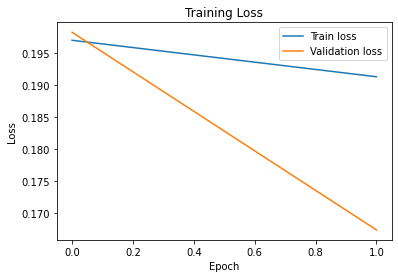

+ Train	 epoch: 3/30	 batch: 500/5366	 loss: 0.16920650005340576
+ Train	 epoch: 3/30	 batch: 1000/5366	 loss: 0.20599965751171112
+ Train	 epoch: 3/30	 batch: 1500/5366	 loss: 0.1685526967048645
+ Train	 epoch: 3/30	 batch: 2000/5366	 loss: 0.21336424350738525
+ Train	 epoch: 3/30	 batch: 2500/5366	 loss: 0.15514884889125824
+ Train	 epoch: 3/30	 batch: 3000/5366	 loss: 0.15962888300418854
+ Train	 epoch: 3/30	 batch: 3500/5366	 loss: 0.18891474604606628
+ Train	 epoch: 3/30	 batch: 4000/5366	 loss: 0.1718336045742035
+ Train	 epoch: 3/30	 batch: 4500/5366	 loss: 0.18023091554641724
+ Train	 epoch: 3/30	 batch: 5000/5366	 loss: 0.18716637790203094
Train	 epoch: 3/30	 loss: 0.1896537508297624
Validation	 epoch: 3/30	 loss: 0.1572275459766388
Saving model


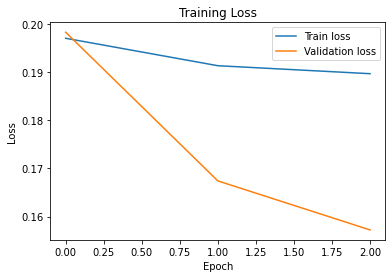

+ Train	 epoch: 4/30	 batch: 500/5366	 loss: 0.18769250810146332
+ Train	 epoch: 4/30	 batch: 1000/5366	 loss: 0.20277726650238037
+ Train	 epoch: 4/30	 batch: 1500/5366	 loss: 0.18144725263118744
+ Train	 epoch: 4/30	 batch: 2000/5366	 loss: 0.18066030740737915
+ Train	 epoch: 4/30	 batch: 2500/5366	 loss: 0.18900452554225922
+ Train	 epoch: 4/30	 batch: 3000/5366	 loss: 0.2234502136707306
+ Train	 epoch: 4/30	 batch: 3500/5366	 loss: 0.18283843994140625
+ Train	 epoch: 4/30	 batch: 4000/5366	 loss: 0.18605460226535797
+ Train	 epoch: 4/30	 batch: 4500/5366	 loss: 0.15112322568893433
+ Train	 epoch: 4/30	 batch: 5000/5366	 loss: 0.16953957080841064
Train	 epoch: 4/30	 loss: 0.18849170392922754
Validation	 epoch: 4/30	 loss: 0.1601380705833435
Saving model


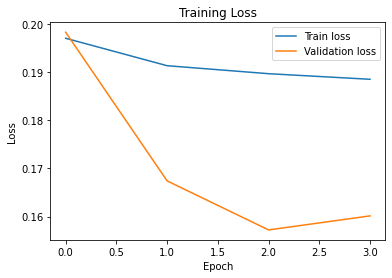

+ Train	 epoch: 5/30	 batch: 500/5366	 loss: 0.15991471707820892
+ Train	 epoch: 5/30	 batch: 1000/5366	 loss: 0.1849077343940735
+ Train	 epoch: 5/30	 batch: 1500/5366	 loss: 0.17753063142299652
+ Train	 epoch: 5/30	 batch: 2000/5366	 loss: 0.1672142595052719
+ Train	 epoch: 5/30	 batch: 2500/5366	 loss: 0.16186203062534332
+ Train	 epoch: 5/30	 batch: 3000/5366	 loss: 0.2866878807544708
+ Train	 epoch: 5/30	 batch: 3500/5366	 loss: 0.1735321283340454
+ Train	 epoch: 5/30	 batch: 4000/5366	 loss: 0.15735554695129395
+ Train	 epoch: 5/30	 batch: 4500/5366	 loss: 0.16012631356716156
+ Train	 epoch: 5/30	 batch: 5000/5366	 loss: 0.15915676951408386
Train	 epoch: 5/30	 loss: 0.18746252297144347
Validation	 epoch: 5/30	 loss: 0.18257012963294983
Saving model


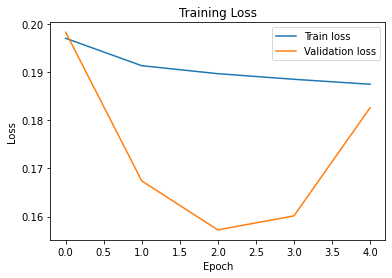

+ Train	 epoch: 6/30	 batch: 500/5366	 loss: 0.20214860141277313
+ Train	 epoch: 6/30	 batch: 1000/5366	 loss: 0.17918473482131958
+ Train	 epoch: 6/30	 batch: 1500/5366	 loss: 0.1877388060092926
+ Train	 epoch: 6/30	 batch: 2000/5366	 loss: 0.21748417615890503
+ Train	 epoch: 6/30	 batch: 2500/5366	 loss: 0.20248986780643463
+ Train	 epoch: 6/30	 batch: 3000/5366	 loss: 0.2064947634935379
+ Train	 epoch: 6/30	 batch: 3500/5366	 loss: 0.1567704826593399
+ Train	 epoch: 6/30	 batch: 4000/5366	 loss: 0.16218353807926178
+ Train	 epoch: 6/30	 batch: 4500/5366	 loss: 0.1697733998298645
+ Train	 epoch: 6/30	 batch: 5000/5366	 loss: 0.18984127044677734
Train	 epoch: 6/30	 loss: 0.18664330641724838
Validation	 epoch: 6/30	 loss: 0.19569770991802216
Saving model


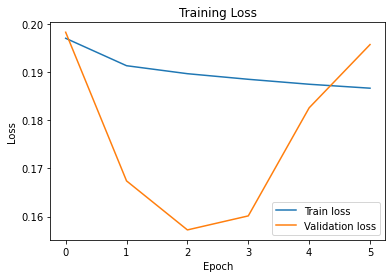

+ Train	 epoch: 7/30	 batch: 500/5366	 loss: 0.20918284356594086
+ Train	 epoch: 7/30	 batch: 1000/5366	 loss: 0.19266211986541748
+ Train	 epoch: 7/30	 batch: 1500/5366	 loss: 0.18320944905281067
+ Train	 epoch: 7/30	 batch: 2000/5366	 loss: 0.1995600163936615
+ Train	 epoch: 7/30	 batch: 2500/5366	 loss: 0.18672901391983032
+ Train	 epoch: 7/30	 batch: 3000/5366	 loss: 0.2168022245168686
+ Train	 epoch: 7/30	 batch: 3500/5366	 loss: 0.24113261699676514
+ Train	 epoch: 7/30	 batch: 4000/5366	 loss: 0.17788362503051758
+ Train	 epoch: 7/30	 batch: 4500/5366	 loss: 0.1557929962873459
+ Train	 epoch: 7/30	 batch: 5000/5366	 loss: 0.17828914523124695
Train	 epoch: 7/30	 loss: 0.18586383119331026
Validation	 epoch: 7/30	 loss: 0.16447924077510834
Saving model


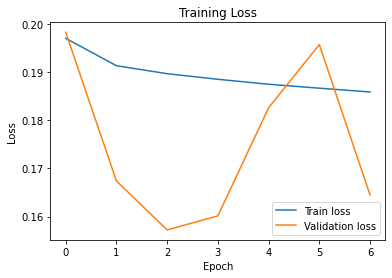

+ Train	 epoch: 8/30	 batch: 500/5366	 loss: 0.1926860511302948
+ Train	 epoch: 8/30	 batch: 1000/5366	 loss: 0.17038246989250183
+ Train	 epoch: 8/30	 batch: 1500/5366	 loss: 0.2317766547203064
+ Train	 epoch: 8/30	 batch: 2000/5366	 loss: 0.1941864788532257
+ Train	 epoch: 8/30	 batch: 2500/5366	 loss: 0.1871577650308609
+ Train	 epoch: 8/30	 batch: 3000/5366	 loss: 0.16910302639007568
+ Train	 epoch: 8/30	 batch: 3500/5366	 loss: 0.18519511818885803
+ Train	 epoch: 8/30	 batch: 4000/5366	 loss: 0.2139478325843811
+ Train	 epoch: 8/30	 batch: 4500/5366	 loss: 0.16169822216033936
+ Train	 epoch: 8/30	 batch: 5000/5366	 loss: 0.1632257103919983
Train	 epoch: 8/30	 loss: 0.18520393839610677
Validation	 epoch: 8/30	 loss: 0.1966569423675537
Saving model


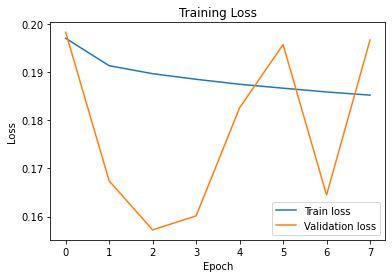

+ Train	 epoch: 9/30	 batch: 500/5366	 loss: 0.17730523645877838
+ Train	 epoch: 9/30	 batch: 1000/5366	 loss: 0.1686185747385025
+ Train	 epoch: 9/30	 batch: 1500/5366	 loss: 0.17752768099308014
+ Train	 epoch: 9/30	 batch: 2000/5366	 loss: 0.1752852499485016
+ Train	 epoch: 9/30	 batch: 2500/5366	 loss: 0.16384223103523254
+ Train	 epoch: 9/30	 batch: 3000/5366	 loss: 0.1687411069869995
+ Train	 epoch: 9/30	 batch: 3500/5366	 loss: 0.17157500982284546
+ Train	 epoch: 9/30	 batch: 4000/5366	 loss: 0.24018794298171997
+ Train	 epoch: 9/30	 batch: 4500/5366	 loss: 0.1614081859588623
+ Train	 epoch: 9/30	 batch: 5000/5366	 loss: 0.21626955270767212
Train	 epoch: 9/30	 loss: 0.1842994486418092
Validation	 epoch: 9/30	 loss: 0.1781512349843979
Saving model


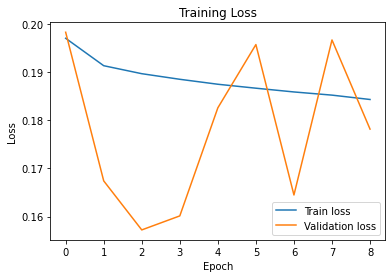

+ Train	 epoch: 10/30	 batch: 500/5366	 loss: 0.19653674960136414
+ Train	 epoch: 10/30	 batch: 1000/5366	 loss: 0.23922421038150787
+ Train	 epoch: 10/30	 batch: 1500/5366	 loss: 0.16184671223163605
+ Train	 epoch: 10/30	 batch: 2000/5366	 loss: 0.1554800122976303
+ Train	 epoch: 10/30	 batch: 2500/5366	 loss: 0.1861632764339447
+ Train	 epoch: 10/30	 batch: 3000/5366	 loss: 0.20267032086849213
+ Train	 epoch: 10/30	 batch: 3500/5366	 loss: 0.16392090916633606
+ Train	 epoch: 10/30	 batch: 4000/5366	 loss: 0.16681282222270966
+ Train	 epoch: 10/30	 batch: 4500/5366	 loss: 0.19790929555892944
+ Train	 epoch: 10/30	 batch: 5000/5366	 loss: 0.19116200506687164
Train	 epoch: 10/30	 loss: 0.18375006445554756
Validation	 epoch: 10/30	 loss: 0.18822690844535828
Saving model


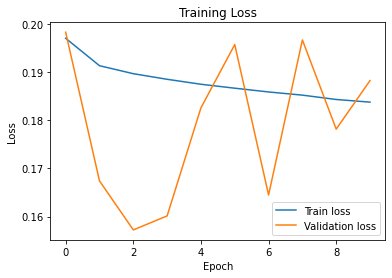

+ Train	 epoch: 11/30	 batch: 500/5366	 loss: 0.16459141671657562
+ Train	 epoch: 11/30	 batch: 1000/5366	 loss: 0.1601923406124115
+ Train	 epoch: 11/30	 batch: 1500/5366	 loss: 0.17566189169883728
+ Train	 epoch: 11/30	 batch: 2000/5366	 loss: 0.1657733917236328
+ Train	 epoch: 11/30	 batch: 2500/5366	 loss: 0.16237017512321472
+ Train	 epoch: 11/30	 batch: 3000/5366	 loss: 0.17353448271751404
+ Train	 epoch: 11/30	 batch: 3500/5366	 loss: 0.20455209910869598
+ Train	 epoch: 11/30	 batch: 4000/5366	 loss: 0.1804577261209488
+ Train	 epoch: 11/30	 batch: 4500/5366	 loss: 0.15665337443351746
+ Train	 epoch: 11/30	 batch: 5000/5366	 loss: 0.17488372325897217
Train	 epoch: 11/30	 loss: 0.1834251370046328
Validation	 epoch: 11/30	 loss: 0.17443831264972687
Saving model


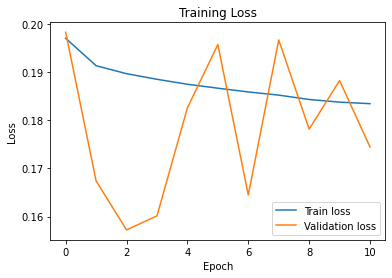

+ Train	 epoch: 12/30	 batch: 500/5366	 loss: 0.1869916170835495
+ Train	 epoch: 12/30	 batch: 1000/5366	 loss: 0.16865766048431396
+ Train	 epoch: 12/30	 batch: 1500/5366	 loss: 0.1821739375591278
+ Train	 epoch: 12/30	 batch: 2000/5366	 loss: 0.1710709184408188
+ Train	 epoch: 12/30	 batch: 2500/5366	 loss: 0.17452369630336761
+ Train	 epoch: 12/30	 batch: 3000/5366	 loss: 0.1669413447380066
+ Train	 epoch: 12/30	 batch: 3500/5366	 loss: 0.1876736432313919
+ Train	 epoch: 12/30	 batch: 4000/5366	 loss: 0.20045623183250427
+ Train	 epoch: 12/30	 batch: 4500/5366	 loss: 0.16683544218540192
+ Train	 epoch: 12/30	 batch: 5000/5366	 loss: 0.1682353913784027
Train	 epoch: 12/30	 loss: 0.18295022915803005
Validation	 epoch: 12/30	 loss: 0.16465994715690613
Saving model


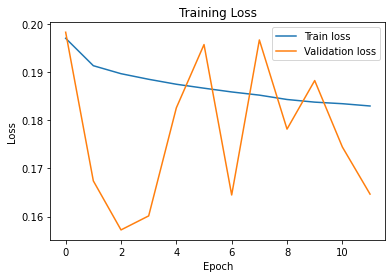

+ Train	 epoch: 13/30	 batch: 500/5366	 loss: 0.15766191482543945
+ Train	 epoch: 13/30	 batch: 1000/5366	 loss: 0.1983325481414795
+ Train	 epoch: 13/30	 batch: 1500/5366	 loss: 0.18408536911010742
+ Train	 epoch: 13/30	 batch: 2000/5366	 loss: 0.1967865526676178
+ Train	 epoch: 13/30	 batch: 2500/5366	 loss: 0.1779744029045105
+ Train	 epoch: 13/30	 batch: 3000/5366	 loss: 0.18608026206493378
+ Train	 epoch: 13/30	 batch: 3500/5366	 loss: 0.18878056108951569
+ Train	 epoch: 13/30	 batch: 4000/5366	 loss: 0.21149948239326477
+ Train	 epoch: 13/30	 batch: 4500/5366	 loss: 0.16568386554718018
+ Train	 epoch: 13/30	 batch: 5000/5366	 loss: 0.17923739552497864
Train	 epoch: 13/30	 loss: 0.18256384742168896
Validation	 epoch: 13/30	 loss: 0.1725589483976364
Saving model


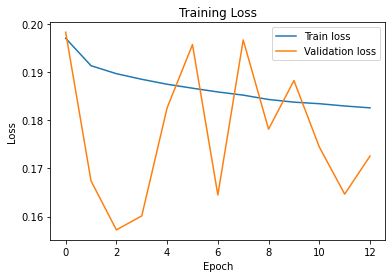

+ Train	 epoch: 14/30	 batch: 500/5366	 loss: 0.20034727454185486
+ Train	 epoch: 14/30	 batch: 1000/5366	 loss: 0.1713522970676422
+ Train	 epoch: 14/30	 batch: 1500/5366	 loss: 0.21704325079917908
+ Train	 epoch: 14/30	 batch: 2000/5366	 loss: 0.17752858996391296
+ Train	 epoch: 14/30	 batch: 2500/5366	 loss: 0.18215900659561157
+ Train	 epoch: 14/30	 batch: 3000/5366	 loss: 0.20542579889297485
+ Train	 epoch: 14/30	 batch: 3500/5366	 loss: 0.1808093786239624
+ Train	 epoch: 14/30	 batch: 4000/5366	 loss: 0.17578744888305664
+ Train	 epoch: 14/30	 batch: 4500/5366	 loss: 0.1629735678434372
+ Train	 epoch: 14/30	 batch: 5000/5366	 loss: 0.1700984239578247
Train	 epoch: 14/30	 loss: 0.18212235793388026
Validation	 epoch: 14/30	 loss: 0.2288021445274353
Saving model


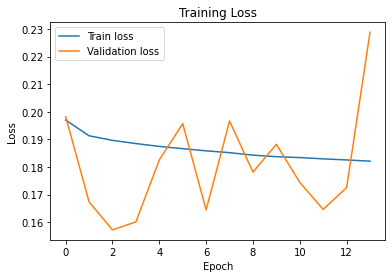

+ Train	 epoch: 15/30	 batch: 500/5366	 loss: 0.16112372279167175
+ Train	 epoch: 15/30	 batch: 1000/5366	 loss: 0.1781809777021408
+ Train	 epoch: 15/30	 batch: 1500/5366	 loss: 0.18382231891155243
+ Train	 epoch: 15/30	 batch: 2000/5366	 loss: 0.18371917307376862
+ Train	 epoch: 15/30	 batch: 2500/5366	 loss: 0.25228941440582275
+ Train	 epoch: 15/30	 batch: 3000/5366	 loss: 0.156418114900589
+ Train	 epoch: 15/30	 batch: 3500/5366	 loss: 0.20528264343738556
+ Train	 epoch: 15/30	 batch: 4000/5366	 loss: 0.16902117431163788
+ Train	 epoch: 15/30	 batch: 4500/5366	 loss: 0.15510053932666779
+ Train	 epoch: 15/30	 batch: 5000/5366	 loss: 0.2014981508255005
Train	 epoch: 15/30	 loss: 0.1817467478487503
Validation	 epoch: 15/30	 loss: 0.24952459335327148
Saving model


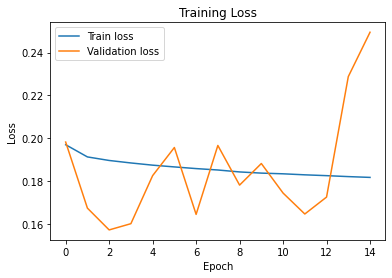

KeyboardInterrupt: 

In [15]:
if ph2_saved:
  savePath = savePath_base+"TTNet_Phase2_1.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph2_train_loss_log = checkpoint['train_loss_log']
  ph2_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 2 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase1_new_val/TTNet_Phase1_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  pretrained_dict = load_weights_local_stage(pretrained_dict)
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 2: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 2: Local + Event Stage ...')

for epoch in range(start_epoch+1, ph2_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()
    
    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

    # Model forward step
    with autocast():
      _, local_out, _, crop_params, event_out = model(window_batch)

    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (local+event) loss
    with autocast():
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = local_loss_train + event_loss_train
    
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph2_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainimg losses
  print(f"Train\t epoch: {epoch}/{ph2_epochs}\t loss: {train_loss_total/batch_num}")
  ph2_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      with autocast():
        _, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (local+event) loss
      with autocast():
        local_loss_val = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_val = event_loss(event_out,event_probs) * event_weight
        val_loss = local_loss_val + event_loss_val

      loss = train_loss.detach().cpu().numpy()
      val_loss_total += loss
      #val_loss_total += val_loss.item()

    ph2_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph2_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"Phase2_new_val/TTNet_Phase2_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph2_train_loss_log,'val_loss_log':ph2_val_loss_log}
  torch.save(state, savePath) 
  ph2_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph2.png")
  plt.show()

## Training Phase 3

In [14]:
# Training config
ph3_saved = False
ph3_epochs = 20
global_weight = 1
local_weight = 1
event_weight = 1
ph3_train_loss_log = []
ph3_val_loss_log = []

In [15]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 3: No model to load, start to train at epoch 0
START TO TRAIN PHASE 3: All Stages ...
+ Train	 epoch: 1/20	 batch: 500/5373	 loss: 0.12870855629444122
+ Train	 epoch: 1/20	 batch: 1000/5373	 loss: 0.15121468901634216
+ Train	 epoch: 1/20	 batch: 1500/5373	 loss: 0.1397198587656021
+ Train	 epoch: 1/20	 batch: 2000/5373	 loss: 0.12285864353179932
+ Train	 epoch: 1/20	 batch: 2500/5373	 loss: 0.1573992669582367
+ Train	 epoch: 1/20	 batch: 3000/5373	 loss: 0.13703641295433044
+ Train	 epoch: 1/20	 batch: 3500/5373	 loss: 0.134092777967453
+ Train	 epoch: 1/20	 batch: 4000/5373	 loss: 0.14080262184143066
+ Train	 epoch: 1/20	 batch: 4500/5373	 loss: 0.17744630575180054
+ Train	 epoch: 1/20	 batch: 5000/5373	 loss: 0.1423064023256302
Train	 epoch: 1/20	 loss: 0.14486721217931814
Validation	 epoch: 1/20	 loss: 0.14589270949363708
Saving model


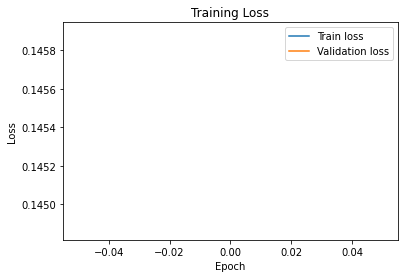

+ Train	 epoch: 2/20	 batch: 500/5373	 loss: 0.15817949175834656
+ Train	 epoch: 2/20	 batch: 1000/5373	 loss: 0.1327589452266693
+ Train	 epoch: 2/20	 batch: 1500/5373	 loss: 0.1347936987876892
+ Train	 epoch: 2/20	 batch: 2000/5373	 loss: 0.1376224160194397
+ Train	 epoch: 2/20	 batch: 2500/5373	 loss: 0.11164990067481995
+ Train	 epoch: 2/20	 batch: 3000/5373	 loss: 0.1378973424434662
+ Train	 epoch: 2/20	 batch: 3500/5373	 loss: 0.12732115387916565
+ Train	 epoch: 2/20	 batch: 4000/5373	 loss: 0.14189374446868896
+ Train	 epoch: 2/20	 batch: 4500/5373	 loss: 0.14906254410743713
+ Train	 epoch: 2/20	 batch: 5000/5373	 loss: 0.16400116682052612
Train	 epoch: 2/20	 loss: 0.14312007868925597
Validation	 epoch: 2/20	 loss: 0.15182927250862122
Saving model


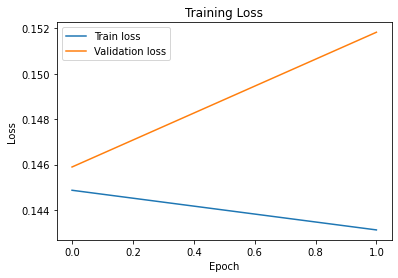

+ Train	 epoch: 3/20	 batch: 500/5373	 loss: 0.14138740301132202
+ Train	 epoch: 3/20	 batch: 1000/5373	 loss: 0.1395128220319748
+ Train	 epoch: 3/20	 batch: 1500/5373	 loss: 0.1283653825521469
+ Train	 epoch: 3/20	 batch: 2000/5373	 loss: 0.13433505594730377
+ Train	 epoch: 3/20	 batch: 2500/5373	 loss: 0.134550541639328
+ Train	 epoch: 3/20	 batch: 3000/5373	 loss: 0.12234082072973251
+ Train	 epoch: 3/20	 batch: 3500/5373	 loss: 0.1691151261329651
+ Train	 epoch: 3/20	 batch: 4000/5373	 loss: 0.10139158368110657
+ Train	 epoch: 3/20	 batch: 4500/5373	 loss: 0.14745798707008362
+ Train	 epoch: 3/20	 batch: 5000/5373	 loss: 0.13793906569480896
Train	 epoch: 3/20	 loss: 0.14157244588062792
Validation	 epoch: 3/20	 loss: 0.12340037524700165
Saving model


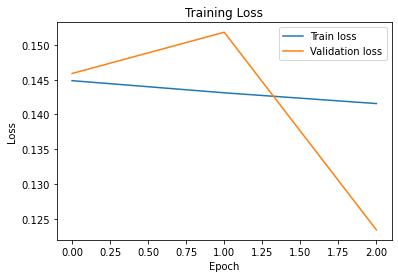

+ Train	 epoch: 4/20	 batch: 500/5373	 loss: 0.15298742055892944
+ Train	 epoch: 4/20	 batch: 1000/5373	 loss: 0.11437475681304932
+ Train	 epoch: 4/20	 batch: 1500/5373	 loss: 0.13850125670433044
+ Train	 epoch: 4/20	 batch: 2000/5373	 loss: 0.14791834354400635
+ Train	 epoch: 4/20	 batch: 2500/5373	 loss: 0.16495569050312042
+ Train	 epoch: 4/20	 batch: 3000/5373	 loss: 0.1246211975812912
+ Train	 epoch: 4/20	 batch: 3500/5373	 loss: 0.1651151478290558
+ Train	 epoch: 4/20	 batch: 4000/5373	 loss: 0.15711694955825806
+ Train	 epoch: 4/20	 batch: 4500/5373	 loss: 0.13738960027694702
+ Train	 epoch: 4/20	 batch: 5000/5373	 loss: 0.14245754480361938
Train	 epoch: 4/20	 loss: 0.1401255990614466
Validation	 epoch: 4/20	 loss: 0.13617604970932007
Saving model


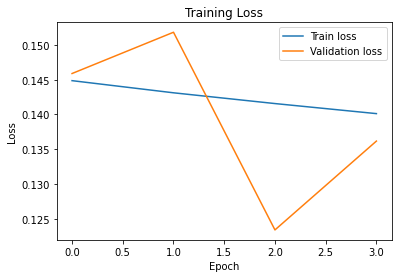

+ Train	 epoch: 5/20	 batch: 500/5373	 loss: 0.14014488458633423
+ Train	 epoch: 5/20	 batch: 1000/5373	 loss: 0.14586728811264038
+ Train	 epoch: 5/20	 batch: 1500/5373	 loss: 0.13577967882156372
+ Train	 epoch: 5/20	 batch: 2000/5373	 loss: 0.10918814688920975
+ Train	 epoch: 5/20	 batch: 2500/5373	 loss: 0.14793121814727783
+ Train	 epoch: 5/20	 batch: 3000/5373	 loss: 0.15786299109458923
+ Train	 epoch: 5/20	 batch: 3500/5373	 loss: 0.13077907264232635
+ Train	 epoch: 5/20	 batch: 4000/5373	 loss: 0.16505929827690125
+ Train	 epoch: 5/20	 batch: 4500/5373	 loss: 0.13468299806118011
+ Train	 epoch: 5/20	 batch: 5000/5373	 loss: 0.13538095355033875
Train	 epoch: 5/20	 loss: 0.13894805507538552
Validation	 epoch: 5/20	 loss: 0.15680494904518127
Saving model


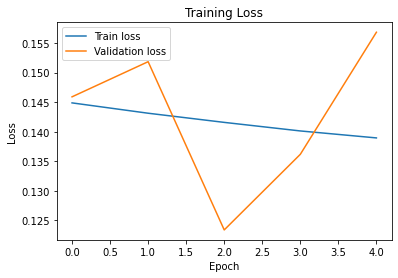

+ Train	 epoch: 6/20	 batch: 500/5373	 loss: 0.11947616934776306
+ Train	 epoch: 6/20	 batch: 1000/5373	 loss: 0.139863982796669
+ Train	 epoch: 6/20	 batch: 1500/5373	 loss: 0.17220813035964966
+ Train	 epoch: 6/20	 batch: 2000/5373	 loss: 0.14522412419319153
+ Train	 epoch: 6/20	 batch: 2500/5373	 loss: 0.12712611258029938
+ Train	 epoch: 6/20	 batch: 3000/5373	 loss: 0.13280674815177917
+ Train	 epoch: 6/20	 batch: 3500/5373	 loss: 0.15746532380580902
+ Train	 epoch: 6/20	 batch: 4000/5373	 loss: 0.1318317949771881
+ Train	 epoch: 6/20	 batch: 4500/5373	 loss: 0.1308051496744156
+ Train	 epoch: 6/20	 batch: 5000/5373	 loss: 0.1351315975189209
Train	 epoch: 6/20	 loss: 0.1378486621497442
Validation	 epoch: 6/20	 loss: 0.13074173033237457
Saving model


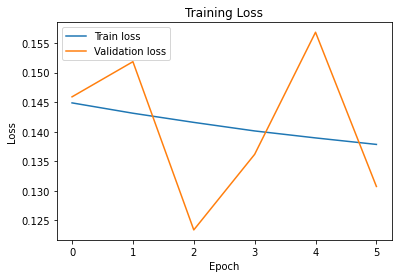

+ Train	 epoch: 7/20	 batch: 500/5373	 loss: 0.11074497550725937
+ Train	 epoch: 7/20	 batch: 1000/5373	 loss: 0.1511843204498291
+ Train	 epoch: 7/20	 batch: 1500/5373	 loss: 0.13805058598518372
+ Train	 epoch: 7/20	 batch: 2000/5373	 loss: 0.1113780289888382
+ Train	 epoch: 7/20	 batch: 2500/5373	 loss: 0.12338526546955109
+ Train	 epoch: 7/20	 batch: 3000/5373	 loss: 0.141841322183609
+ Train	 epoch: 7/20	 batch: 3500/5373	 loss: 0.1436668336391449
+ Train	 epoch: 7/20	 batch: 4000/5373	 loss: 0.16429337859153748
+ Train	 epoch: 7/20	 batch: 4500/5373	 loss: 0.1314961463212967
+ Train	 epoch: 7/20	 batch: 5000/5373	 loss: 0.17131346464157104
Train	 epoch: 7/20	 loss: 0.13658150994348367
Validation	 epoch: 7/20	 loss: 0.12841032445430756
Saving model


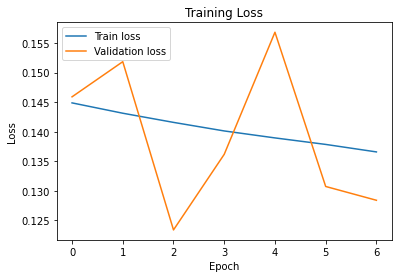

+ Train	 epoch: 8/20	 batch: 500/5373	 loss: 0.14959660172462463
+ Train	 epoch: 8/20	 batch: 1000/5373	 loss: 0.10268249362707138
+ Train	 epoch: 8/20	 batch: 1500/5373	 loss: 0.13574905693531036
+ Train	 epoch: 8/20	 batch: 2000/5373	 loss: 0.13226431608200073
+ Train	 epoch: 8/20	 batch: 2500/5373	 loss: 0.14818719029426575
+ Train	 epoch: 8/20	 batch: 3000/5373	 loss: 0.14229385554790497
+ Train	 epoch: 8/20	 batch: 3500/5373	 loss: 0.13860729336738586
+ Train	 epoch: 8/20	 batch: 4000/5373	 loss: 0.12835296988487244
+ Train	 epoch: 8/20	 batch: 4500/5373	 loss: 0.09750895202159882
+ Train	 epoch: 8/20	 batch: 5000/5373	 loss: 0.1298644244670868
Train	 epoch: 8/20	 loss: 0.13542346403116445
Validation	 epoch: 8/20	 loss: 0.11867394298315048
Saving model


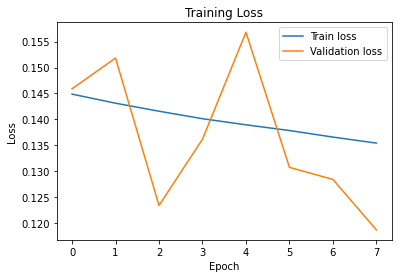

+ Train	 epoch: 9/20	 batch: 500/5373	 loss: 0.13880819082260132
+ Train	 epoch: 9/20	 batch: 1000/5373	 loss: 0.13944274187088013
+ Train	 epoch: 9/20	 batch: 1500/5373	 loss: 0.1364816129207611
+ Train	 epoch: 9/20	 batch: 2000/5373	 loss: 0.1284211277961731
+ Train	 epoch: 9/20	 batch: 2500/5373	 loss: 0.14820095896720886
+ Train	 epoch: 9/20	 batch: 3000/5373	 loss: 0.11696264147758484
+ Train	 epoch: 9/20	 batch: 3500/5373	 loss: 0.12584348022937775
+ Train	 epoch: 9/20	 batch: 4000/5373	 loss: 0.130476713180542
+ Train	 epoch: 9/20	 batch: 4500/5373	 loss: 0.11255206167697906
+ Train	 epoch: 9/20	 batch: 5000/5373	 loss: 0.1528872549533844
Train	 epoch: 9/20	 loss: 0.134731399539838
Validation	 epoch: 9/20	 loss: 0.11513738334178925
Saving model


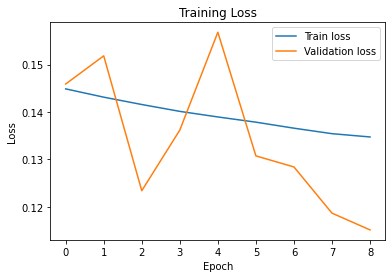

+ Train	 epoch: 10/20	 batch: 500/5373	 loss: 0.1255708634853363
+ Train	 epoch: 10/20	 batch: 1000/5373	 loss: 0.10652242600917816
+ Train	 epoch: 10/20	 batch: 1500/5373	 loss: 0.096066914498806
+ Train	 epoch: 10/20	 batch: 2000/5373	 loss: 0.13113638758659363
+ Train	 epoch: 10/20	 batch: 2500/5373	 loss: 0.13485701382160187
+ Train	 epoch: 10/20	 batch: 3000/5373	 loss: 0.1306256800889969
+ Train	 epoch: 10/20	 batch: 3500/5373	 loss: 0.1333540380001068
+ Train	 epoch: 10/20	 batch: 4000/5373	 loss: 0.11884906142950058
+ Train	 epoch: 10/20	 batch: 4500/5373	 loss: 0.1666516363620758
+ Train	 epoch: 10/20	 batch: 5000/5373	 loss: 0.1468522548675537
Train	 epoch: 10/20	 loss: 0.13368434099407364
Validation	 epoch: 10/20	 loss: 0.12540343403816223
Saving model


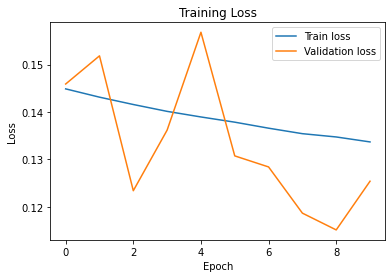

+ Train	 epoch: 11/20	 batch: 500/5373	 loss: 0.1267613172531128
+ Train	 epoch: 11/20	 batch: 1000/5373	 loss: 0.13530509173870087
+ Train	 epoch: 11/20	 batch: 1500/5373	 loss: 0.13171976804733276
+ Train	 epoch: 11/20	 batch: 2000/5373	 loss: 0.1360251009464264
+ Train	 epoch: 11/20	 batch: 2500/5373	 loss: 0.10336913913488388
+ Train	 epoch: 11/20	 batch: 3000/5373	 loss: 0.1207096204161644
+ Train	 epoch: 11/20	 batch: 3500/5373	 loss: 0.13847684860229492
+ Train	 epoch: 11/20	 batch: 4000/5373	 loss: 0.15128862857818604
+ Train	 epoch: 11/20	 batch: 4500/5373	 loss: 0.1381406933069229
+ Train	 epoch: 11/20	 batch: 5000/5373	 loss: 0.12374678254127502
Train	 epoch: 11/20	 loss: 0.1330314479406355
Validation	 epoch: 11/20	 loss: 0.1263611763715744
Saving model


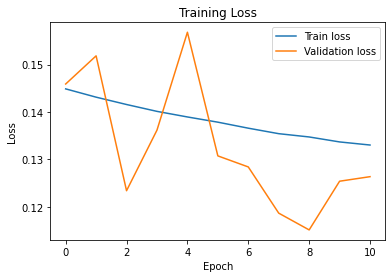

+ Train	 epoch: 12/20	 batch: 500/5373	 loss: 0.13893231749534607
+ Train	 epoch: 12/20	 batch: 1000/5373	 loss: 0.10962893813848495
+ Train	 epoch: 12/20	 batch: 1500/5373	 loss: 0.15022334456443787
+ Train	 epoch: 12/20	 batch: 2000/5373	 loss: 0.12162759900093079
+ Train	 epoch: 12/20	 batch: 2500/5373	 loss: 0.14504462480545044
+ Train	 epoch: 12/20	 batch: 3000/5373	 loss: 0.11745668202638626
+ Train	 epoch: 12/20	 batch: 3500/5373	 loss: 0.12198778241872787
+ Train	 epoch: 12/20	 batch: 4000/5373	 loss: 0.13027231395244598
+ Train	 epoch: 12/20	 batch: 4500/5373	 loss: 0.14944520592689514
+ Train	 epoch: 12/20	 batch: 5000/5373	 loss: 0.09938661754131317
Train	 epoch: 12/20	 loss: 0.13207072048974441
Validation	 epoch: 12/20	 loss: 0.11408677697181702
Saving model


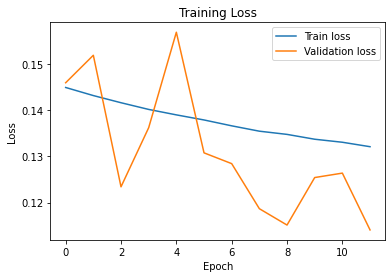

+ Train	 epoch: 13/20	 batch: 500/5373	 loss: 0.13086894154548645
+ Train	 epoch: 13/20	 batch: 1000/5373	 loss: 0.11867469549179077
+ Train	 epoch: 13/20	 batch: 1500/5373	 loss: 0.1295349895954132
+ Train	 epoch: 13/20	 batch: 2000/5373	 loss: 0.14072227478027344
+ Train	 epoch: 13/20	 batch: 2500/5373	 loss: 0.12997809052467346
+ Train	 epoch: 13/20	 batch: 3000/5373	 loss: 0.12963001430034637
+ Train	 epoch: 13/20	 batch: 3500/5373	 loss: 0.1353348195552826
+ Train	 epoch: 13/20	 batch: 4000/5373	 loss: 0.14232757687568665
+ Train	 epoch: 13/20	 batch: 4500/5373	 loss: 0.13498622179031372
+ Train	 epoch: 13/20	 batch: 5000/5373	 loss: 0.11476564407348633
Train	 epoch: 13/20	 loss: 0.1314269587613896
Validation	 epoch: 13/20	 loss: 0.15844371914863586
Saving model


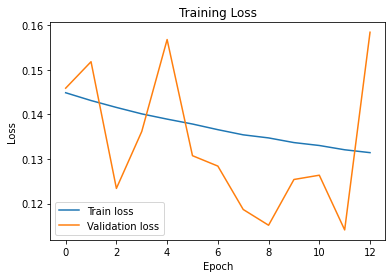

+ Train	 epoch: 14/20	 batch: 500/5373	 loss: 0.1384720802307129
+ Train	 epoch: 14/20	 batch: 1000/5373	 loss: 0.1261146366596222
+ Train	 epoch: 14/20	 batch: 1500/5373	 loss: 0.09316310286521912
+ Train	 epoch: 14/20	 batch: 2000/5373	 loss: 0.11091935634613037
+ Train	 epoch: 14/20	 batch: 2500/5373	 loss: 0.12222029268741608
+ Train	 epoch: 14/20	 batch: 3000/5373	 loss: 0.10647141933441162
+ Train	 epoch: 14/20	 batch: 3500/5373	 loss: 0.10184453427791595
+ Train	 epoch: 14/20	 batch: 4000/5373	 loss: 0.14435890316963196
+ Train	 epoch: 14/20	 batch: 4500/5373	 loss: 0.1505689024925232
+ Train	 epoch: 14/20	 batch: 5000/5373	 loss: 0.13043753802776337
Train	 epoch: 14/20	 loss: 0.13060031459498134
Validation	 epoch: 14/20	 loss: 0.14058764278888702
Saving model


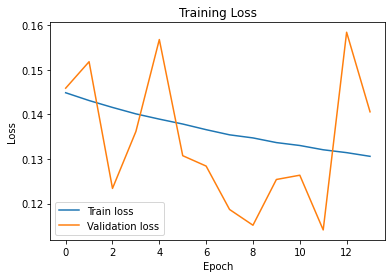

+ Train	 epoch: 15/20	 batch: 500/5373	 loss: 0.12884151935577393
+ Train	 epoch: 15/20	 batch: 1000/5373	 loss: 0.2018052041530609
+ Train	 epoch: 15/20	 batch: 1500/5373	 loss: 0.10301409661769867
+ Train	 epoch: 15/20	 batch: 2000/5373	 loss: 0.12996806204319
+ Train	 epoch: 15/20	 batch: 2500/5373	 loss: 0.12173345685005188
+ Train	 epoch: 15/20	 batch: 3000/5373	 loss: 0.1156417727470398
+ Train	 epoch: 15/20	 batch: 3500/5373	 loss: 0.12348878383636475
+ Train	 epoch: 15/20	 batch: 4000/5373	 loss: 0.12502825260162354
+ Train	 epoch: 15/20	 batch: 4500/5373	 loss: 0.13049015402793884
+ Train	 epoch: 15/20	 batch: 5000/5373	 loss: 0.1257331371307373
Train	 epoch: 15/20	 loss: 0.129870388918242
Validation	 epoch: 15/20	 loss: 0.116457998752594
Saving model


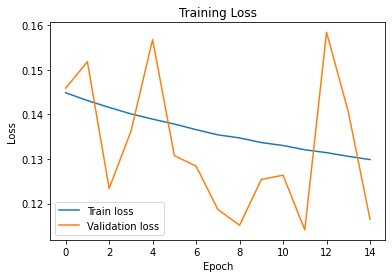

+ Train	 epoch: 16/20	 batch: 500/5373	 loss: 0.12016941606998444
+ Train	 epoch: 16/20	 batch: 1000/5373	 loss: 0.10262167453765869
+ Train	 epoch: 16/20	 batch: 1500/5373	 loss: 0.14324453473091125
+ Train	 epoch: 16/20	 batch: 2000/5373	 loss: 0.11846477538347244
+ Train	 epoch: 16/20	 batch: 2500/5373	 loss: 0.13599270582199097
+ Train	 epoch: 16/20	 batch: 3000/5373	 loss: 0.12355425953865051
+ Train	 epoch: 16/20	 batch: 3500/5373	 loss: 0.146495521068573
+ Train	 epoch: 16/20	 batch: 4000/5373	 loss: 0.14963342249393463
+ Train	 epoch: 16/20	 batch: 4500/5373	 loss: 0.11439183354377747
+ Train	 epoch: 16/20	 batch: 5000/5373	 loss: 0.10745811462402344
Train	 epoch: 16/20	 loss: 0.12906912117835953
Validation	 epoch: 16/20	 loss: 0.12987899780273438
Saving model


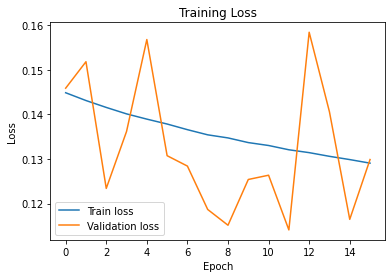

+ Train	 epoch: 17/20	 batch: 500/5373	 loss: 0.11341806501150131
+ Train	 epoch: 17/20	 batch: 1000/5373	 loss: 0.11745817959308624
+ Train	 epoch: 17/20	 batch: 1500/5373	 loss: 0.1373901665210724
+ Train	 epoch: 17/20	 batch: 2000/5373	 loss: 0.11517181992530823
+ Train	 epoch: 17/20	 batch: 2500/5373	 loss: 0.11933203786611557
+ Train	 epoch: 17/20	 batch: 3000/5373	 loss: 0.11781516671180725
+ Train	 epoch: 17/20	 batch: 3500/5373	 loss: 0.13365671038627625
+ Train	 epoch: 17/20	 batch: 4000/5373	 loss: 0.13920672237873077
+ Train	 epoch: 17/20	 batch: 4500/5373	 loss: 0.10681456327438354
+ Train	 epoch: 17/20	 batch: 5000/5373	 loss: 0.14062198996543884
Train	 epoch: 17/20	 loss: 0.12858945906589356
Validation	 epoch: 17/20	 loss: 0.13206888735294342
Saving model


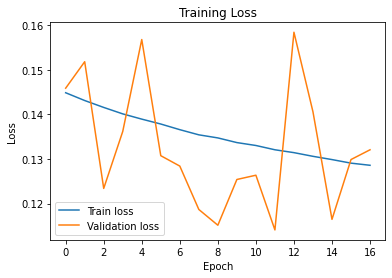

+ Train	 epoch: 18/20	 batch: 500/5373	 loss: 0.11187224090099335
+ Train	 epoch: 18/20	 batch: 1000/5373	 loss: 0.16139069199562073
+ Train	 epoch: 18/20	 batch: 1500/5373	 loss: 0.11298613250255585
+ Train	 epoch: 18/20	 batch: 2000/5373	 loss: 0.13107292354106903
+ Train	 epoch: 18/20	 batch: 2500/5373	 loss: 0.14643068611621857
+ Train	 epoch: 18/20	 batch: 3000/5373	 loss: 0.12448552250862122
+ Train	 epoch: 18/20	 batch: 3500/5373	 loss: 0.11814188212156296
+ Train	 epoch: 18/20	 batch: 4000/5373	 loss: 0.09893188625574112
+ Train	 epoch: 18/20	 batch: 4500/5373	 loss: 0.13990020751953125
+ Train	 epoch: 18/20	 batch: 5000/5373	 loss: 0.1244255006313324
Train	 epoch: 18/20	 loss: 0.1279375472593281
Validation	 epoch: 18/20	 loss: 0.1344836801290512
Saving model


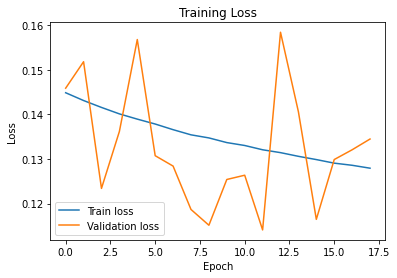

+ Train	 epoch: 19/20	 batch: 500/5373	 loss: 0.10330604761838913
+ Train	 epoch: 19/20	 batch: 1000/5373	 loss: 0.12978199124336243
+ Train	 epoch: 19/20	 batch: 1500/5373	 loss: 0.10288752615451813
+ Train	 epoch: 19/20	 batch: 2000/5373	 loss: 0.11040781438350677
+ Train	 epoch: 19/20	 batch: 2500/5373	 loss: 0.1325618028640747
+ Train	 epoch: 19/20	 batch: 3000/5373	 loss: 0.11525041610002518
+ Train	 epoch: 19/20	 batch: 3500/5373	 loss: 0.12045425921678543
+ Train	 epoch: 19/20	 batch: 4000/5373	 loss: 0.14681142568588257
+ Train	 epoch: 19/20	 batch: 4500/5373	 loss: 0.14584946632385254
+ Train	 epoch: 19/20	 batch: 5000/5373	 loss: 0.13523393869400024
Train	 epoch: 19/20	 loss: 0.12731048233339778
Validation	 epoch: 19/20	 loss: 0.11400139331817627
Saving model


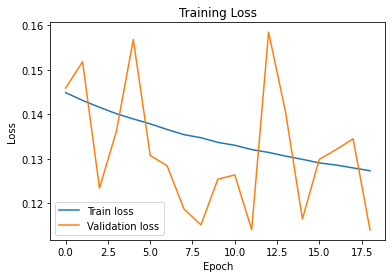

+ Train	 epoch: 20/20	 batch: 500/5373	 loss: 0.17135512828826904
+ Train	 epoch: 20/20	 batch: 1000/5373	 loss: 0.12408944964408875
+ Train	 epoch: 20/20	 batch: 1500/5373	 loss: 0.12618640065193176
+ Train	 epoch: 20/20	 batch: 2000/5373	 loss: 0.1052914559841156
+ Train	 epoch: 20/20	 batch: 2500/5373	 loss: 0.12275151908397675
+ Train	 epoch: 20/20	 batch: 3000/5373	 loss: 0.12362466752529144
+ Train	 epoch: 20/20	 batch: 3500/5373	 loss: 0.12377078831195831
+ Train	 epoch: 20/20	 batch: 4000/5373	 loss: 0.09797437489032745
+ Train	 epoch: 20/20	 batch: 4500/5373	 loss: 0.15773619711399078
+ Train	 epoch: 20/20	 batch: 5000/5373	 loss: 0.09059825539588928
Train	 epoch: 20/20	 loss: 0.1267131409766775
Validation	 epoch: 20/20	 loss: 0.1344183385372162
Saving model


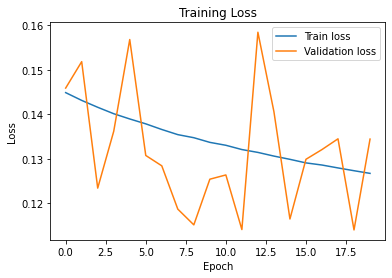

In [16]:
if ph3_saved:
  savePath = savePath_base+"TTNet_Phase3_4.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph3_train_loss_log = checkpoint['train_loss_log']
  ph3_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 3 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"TTNet_Phase2_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 3: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 3: All Stages ...')

for epoch in range(start_epoch+1, ph3_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
    
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

    # Model forward step
    with autocast():
      gloabl_out, local_out, _, crop_params, event_out = model(window_batch)
    
    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (global+local+event) loss
    with autocast():
      global_loss_train = ball_loss(gloabl_out,xy_downscale_batch) * global_weight
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = global_loss_train + local_loss_train + event_loss_train

    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph3_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")
    
    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainig losses
  print(f"Train\t epoch: {epoch}/{ph3_epochs}\t loss: {train_loss_total/batch_num}")
  ph3_train_loss_log.append(train_loss_total/batch_num)


  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step
      with autocast():
        global_out, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (global+local+event) loss
      with autocast():
        global_loss_train = ball_loss(global_out,xy_downscale_batch) * global_weight
        local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_train = event_loss(event_out,event_probs) * event_weight
        val_loss = global_loss_train + local_loss_train + event_loss_train
      
      loss = train_loss.detach().cpu().numpy()
      val_loss_total += loss

    ph3_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph3_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"TTNet_Phase3_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph3_train_loss_log,'val_loss_log':ph3_val_loss_log}
  torch.save(state, savePath) 
  ph3_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph3_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph3_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph3.png")
  plt.show()

## Testing

In [13]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Final/TTNet_Phase3_20.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model'])
window_imgs, xy_downscale, window_centre, event_probs = next(iter(train_loader))  

In [43]:
def save_predict(outputPath_e):
  model.eval()
  with torch.no_grad():   
    event_counter = 0
    for i,data_batch in enumerate(tqdm(test_loader)):
      # Read in test bacth
      window_imgs, xy_downscale, window_centre, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      global_out, local_out, local_in, crop_params, event_out = model(window_batch)
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)

      local_out_clone = local_out.clone().detach()
      global_out_clone = global_out.clone().detach()
      event_out_clone = event_out.clone().detach()

      for out_index in range(local_out_clone.shape[0]):  
        pre_event = event_out_clone[out_index]
        ground_event = event_probs[out_index]
        local_output_clone_x = local_out_clone[out_index,:TTN_width]
        local_output_clone_y = local_out_clone[out_index,TTN_width:]

        local_output_x = torch.argmax(local_output_clone_x).item()
        local_output_y = torch.argmax(local_output_clone_y).item()

        global_output_clone_x = global_out_clone[out_index,:TTN_width]
        global_output_clone_y = global_out_clone[out_index,TTN_width:]

        global_output_x = torch.argmax(global_output_clone_x).item()
        global_output_y = torch.argmax(global_output_clone_y).item()

        pred_x = global_output_x*data_width/TTN_width-TTN_width/2+local_output_x
        pred_y = global_output_y*data_height/TTN_height-TTN_height/2+local_output_y

        pred_x = 0 if pred_x<0 else pred_x
        pred_y = 0 if pred_y<0 else pred_y

        ori_x = xy_downscale[0][out_index].item()*(data_width/TTN_width)
        ori_y = xy_downscale[1][out_index].item()*(data_height/TTN_height)
        #print("------")

        #print("Global:\t X: "+str(global_output_x*data_width/TTN_width)+"\t Y:"+str(global_output_y*data_height/TTN_height))
        #print("Local:\t X: "+str(local_output_x*data_width/TTN_width)+"\t Y:"+str(local_output_y*data_height/TTN_height))
        #print("Pred:\t X: "+str(pred_x)+"\t Y:"+str(pred_y))
        #print("Real:\t X: "+str(ori_x)+"\t\t Y:"+str(ori_y))
        ori_image = cv.imread(window_centre[out_index])
        cv.imwrite(  outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Input.jpg" , ori_image )

        vutils.save_image(local_in[out_index][24:], outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Crop_Img.jpg")
        
        cv.circle(ori_image, (int(pred_x),int(pred_y)), 8,  (0, 0, 255), 2)
        cv.circle(ori_image, (int(ori_x),int(ori_y)), 8,  (0, 255, 0), 2)

        if(pre_event[0].item()>=0.9):
          event_text = "Event: Not in image"
          cv.putText(ori_image, event_text, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

        if(pre_event[1].item()>=0.8):
          event_text = "Event: Flying"
          cv.putText(ori_image, event_text, (50, 100), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        if(pre_event[2].item()>=0.8):
          event_text = "Event: Bouncing"
          cv.putText(ori_image, event_text, (50, 150), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

        if(pre_event[3].item()>=0.8):
          event_text = "Event: Hit"
          cv.putText(ori_image, event_text, (50, 200), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)

        if(pre_event[4].item()>=0.8):
          event_text = "Event: Net Contact"
          cv.putText(ori_image, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

        if((pre_event[1].item()>=0.5 and ground_event[1].item()>=0.5) or
          (pre_event[2].item()>=0.5 and ground_event[2].item()>=0.5) or
          (pre_event[3].item()>=0.5 and ground_event[3].item()>=0.5) or
          (pre_event[4].item()>=0.5 and ground_event[4].item()>=0.5)):
          event_counter+=1

        ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = crop_params[out_index]
        cv.rectangle(ori_image, (x_min,y_min), (x_max,y_max), (0,0,255), 2)

        cv.imwrite(outputPath_e+f"{(i*local_out_clone.shape[0]+out_index):04d}"+"_Ori_Img.jpg" , ori_image )

        # Concat image
        cat_img_1 = cv.imread(outputPath_e+f"{(i*local_out_clone.shape[0]+out_index):04d}"+"_Ori_Img.jpg")
        cat_img_1 = cv.resize(cat_img_1, ( data_width , data_height ))

        cat_img_2 = cv.imread(outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Crop_Img.jpg")
        cat_img_2 = cv.resize(cat_img_2, ( data_width , data_height ))

        cat_h_1=cv.hconcat([cat_img_1,cat_img_2])
        cv.imwrite(outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_cat.jpg" , cat_h_1 )

In [44]:
outputPath_e = outputPath+"Predictions/"
folder = os.path.exists(outputPath_e)
if not folder: 
  os.makedirs(outputPath_e)
save_predict(outputPath_e)

100%|██████████| 671/671 [16:23<00:00,  1.47s/it]
